In [1]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from natsort import natsorted
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.special import erfc

import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from datetime import datetime
from datetime import timedelta
import re, os
import h5py
import pandas as pd

In [2]:
import sys
sys.path.insert(0,'../../')
sys.path.insert(0,'../../WaveformAnalysis')

In [3]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
from Waveform import Waveform
from SiPM import SiPM

In [4]:
#load data from files using the SiPM class
data=SiPM(Path='C:/Data/20220525/',Selection='*V*.h5')

#load the Channel attribute
data.Ch=[Waveform(ID=1,Pol=-1)]
print (len(data.Files))

9


In [5]:
#loop over files and load data using the ImportDataFromHDF5 function in Dataset class

data.Files=natsorted(data.Files)
max_array_sh1=[]
max_array_sh2=[]
max_array_sh3=[]
for File in data.Files:
    loaded_data=SiPM(Path=File) # Call the SiPM Class
    loaded_data.Ch=[Waveform(ID=2,Pol=-1)] # Since we only have data from a single channel, we store it in an array
    loaded_data.ImportDataFromHDF5(File,loaded_data.Ch,var=[]) #Import data from the HD5 file with empty var array since we don't need trigger or time stamp
    
    loaded_data.get_sampling()

    loaded_data.sampling_freq
    
    loaded_data.shaping_time=[2e-6,5e-6,10e-6] #List of shaping times to shape the signal with

    loaded_data.setup_butter_filter() # calculate the butterworth filter coefficients 
    
    
    for waveform in loaded_data.Ch[0].Amp: #loop over the waveforms inside the file
        y=loaded_data.get_filtered_waveform(waveform) # return the filtered waveform
       
        max_amp=loaded_data.Ch[0].GetAllMaxima(y)
        # plt.plot(loaded_data.Ch[0].Time,waveform,color='b')
        # [plt.plot(loaded_data.Ch[0].Time,y1) for y1 in y]
        # plt.xlim(500,550)
        # plt.show()
        max_array_sh1.append(max_amp[0])
        max_array_sh2.append(max_amp[1])
        max_array_sh3.append(max_amp[2])

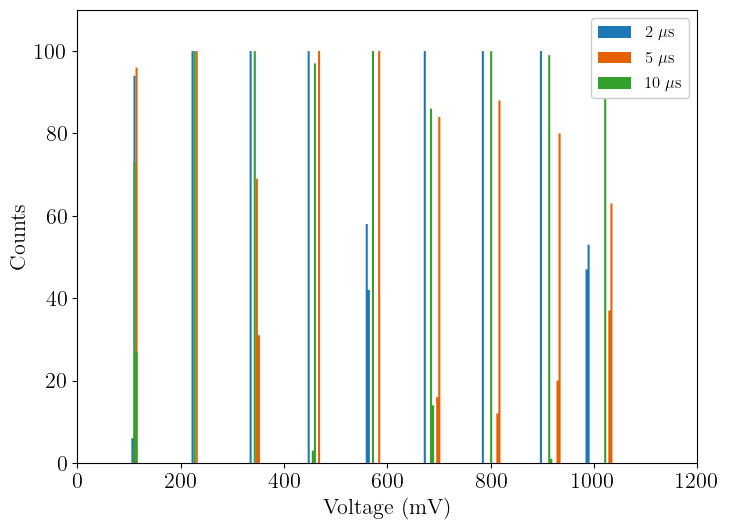

In [6]:
BINS=np.linspace(0,1200,300)
plt.figure(figsize=(8,6))
plt.hist(max_array_sh1,bins=BINS,histtype='stepfilled',label='2 $\mu$s')
plt.hist(max_array_sh2,bins=BINS,histtype='stepfilled',label='5 $\mu$s')
plt.hist(max_array_sh3,bins=BINS,histtype='stepfilled',label='10 $\mu$s')
plt.legend(loc='best')
plt.ylim(0,110)
plt.xlabel('Voltage (mV)')
plt.ylabel('Counts')
plt.show()

In [12]:
print(len(max_array_sh1))
print(np.mean(max_array_sh1[0:100]))

900
109.78316637203812


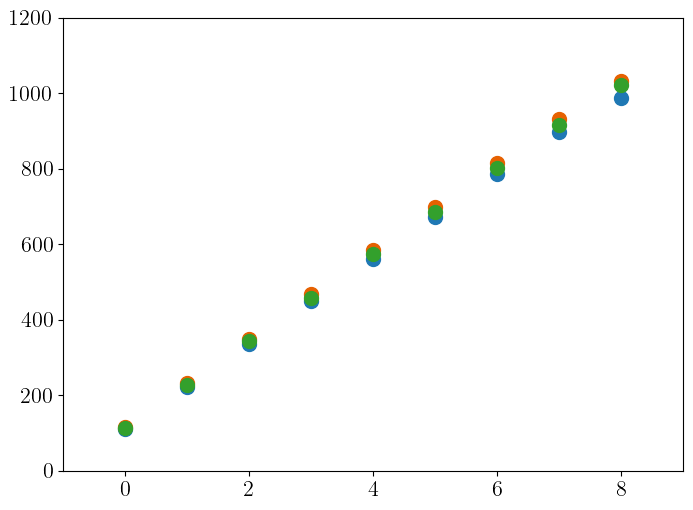

In [42]:
plt.figure(figsize=(8,6))
[plt.scatter(i,np.mean(max_array_sh1[100*i:100*(i+1)]),color=colors[0]) for i in np.arange(0,9,1)]
[plt.scatter(i,np.mean(max_array_sh2[100*i:100*(i+1)]),color=colors[1]) for i in np.arange (0,9,1)]
[plt.scatter(i,np.mean(max_array_sh3[100*i:100*(i+1)]),color=colors[2]) for i in np.arange(0,9,1)]
plt.xlim(-1,9)
plt.show()
